# Skin Disease Detection  - DermNet

In [1]:
!pip install opencv-python


In [2]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import random
import pandas as pd
from collections import Counter
from PIL import Image
import PIL

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
# Path to the folder
data_path= '/content/drive/MyDrive/extracted_data/CV_DermNet/train'

classes=os.listdir(data_path)
# naviage through the subfolders
dic={}
for i in classes:
    dic[i]= len(os.listdir(os.path.join(data_path,i)))
for key,value in dic.items():
    print(key,":",value)
print("\n \n Number of classes:", len(dic))

Acne and Rosacea Photos : 840
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions : 1149
Atopic Dermatitis Photos : 489
Bullous Disease Photos : 448
Cellulitis Impetigo and other Bacterial Infections : 288
Eczema Photos : 1235
Exanthems and Drug Eruptions : 404
Hair Loss Photos Alopecia and other Hair Diseases : 239
Herpes HPV and other STDs Photos : 405
Light Diseases and Disorders of Pigmentation : 568
Lupus and other Connective Tissue diseases : 420
Melanoma Skin Cancer Nevi and Moles : 463
Nail Fungus and other Nail Disease : 1040
Poison Ivy Photos and other Contact Dermatitis : 260
Psoriasis pictures Lichen Planus and related diseases : 1405
Scabies Lyme Disease and other Infestations and Bites : 431
Seborrheic Keratoses and other Benign Tumors : 1371
Systemic Disease : 606
Tinea Ringworm Candidiasis and other Fungal Infections : 1300
Urticaria Hives : 212
Vascular Tumors : 482
Vasculitis Photos : 416
Warts Molluscum and other Viral Infections : 1086

 
 Number of c

#### Visualize the Class Distribution

<ipython-input-43-04cb98905a96>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train_counts_sorted, x="Category", y="Train Image Count", palette="viridis")


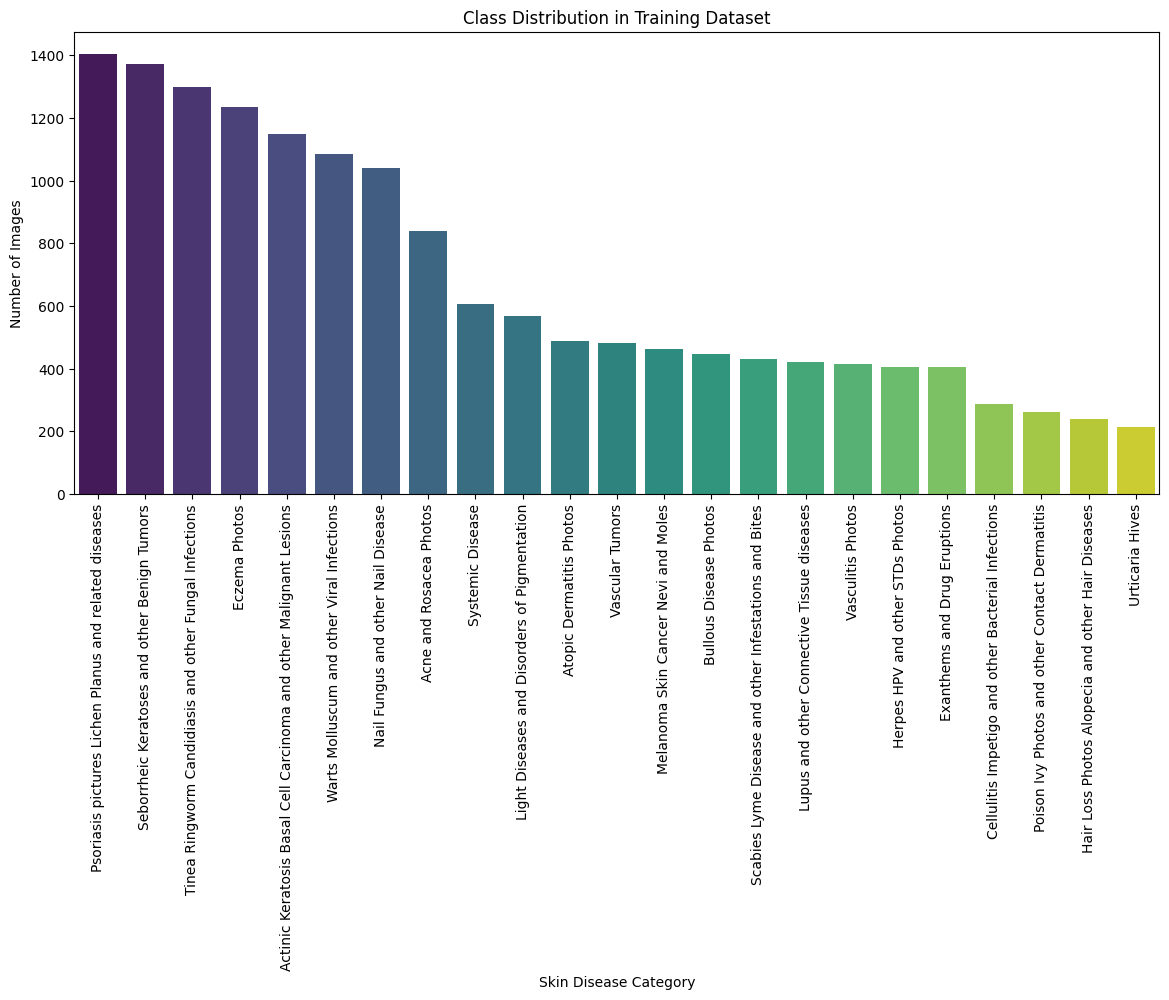

In [43]:
df_train_counts = pd.DataFrame(list(dic.items()), columns=["Category", "Train Image Count"])

# Sorting the dataset by image count for better visualization
df_train_counts_sorted = df_train_counts.sort_values(by="Train Image Count", ascending=False)

# Plot class balance
plt.figure(figsize=(14, 6))
sns.barplot(data=df_train_counts_sorted, x="Category", y="Train Image Count", palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Skin Disease Category")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training Dataset")
plt.show()


In [44]:
plt.figure(figsize=(11, 12))
plt.pie(dic.values(),
        labels=dic.keys(),
        autopct='%1.1f%%',
        startangle=140,
        textprops={'fontsize': 10})

plt.axis('equal')
plt.title('Distribution of Files in Each Class')
plt.show()

There is a slight imbalance in our dataset. Eczema and psorasis seems to be common skin problems and contributes to 8% and 9% of the training images respectively.

### Training and Test set Distribution

In [4]:
train_dir="/content/drive/MyDrive/extracted_data/CV_DermNet/train"
test_dir = "/content/drive/MyDrive/extracted_data/CV_DermNet/test"


In [5]:
# Function to get image count per category
def count_images_in_directory(directory):
    categories = os.listdir(directory)
    category_counts = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            category_counts[category] = len(os.listdir(category_path))
    return category_counts

In [6]:
# Count images in training and test sets
train_counts = count_images_in_directory(train_dir)
test_counts = count_images_in_directory(test_dir)

In [48]:
# Calculate total counts
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
# Create the bar chart
plt.figure(figsize=(6, 4))
bars = plt.bar(['Train', 'Test'], [total_train, total_test], color=['skyblue', 'lightcoral'])
plt.xlabel("Dataset")
plt.ylabel("Total Image Count")
plt.title("Total Images in Train and Test Sets")

# Add text annotations to the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()


### Top 5 Skin conditions in our dataset

In [49]:
# Top 5 Skin conditions
sorted_dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))
top_classes = dict(list(sorted_dic.items())[:5])
for key, value in top_classes.items():
    print(key, ":", value, "\n")

Psoriasis pictures Lichen Planus and related diseases : 1405 

Seborrheic Keratoses and other Benign Tumors : 1371 

Tinea Ringworm Candidiasis and other Fungal Infections : 1300 

Eczema Photos : 1235 

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions : 1149 



### Image Resolution Analysis in training images

In [27]:
# Analyzing image dimensions
image_dimensions = []
for category in train_counts.keys():
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path)
            image_dimensions.append(img.size)
        except (PIL.UnidentifiedImageError, OSError) as e:
            print(f"Warning: Skipping file {img_path} due to error: {e}")

In [28]:
# Convert to DataFrame
df_image_dims = pd.DataFrame(image_dimensions, columns=["Width", "Height"])

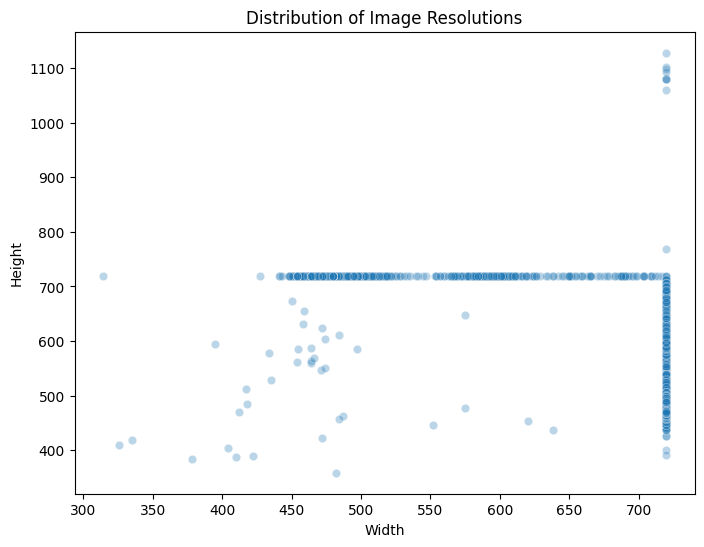

In [32]:
# Plotting image size distribution
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_image_dims, x="Width", y="Height", alpha=0.3)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Resolutions")
plt.show()


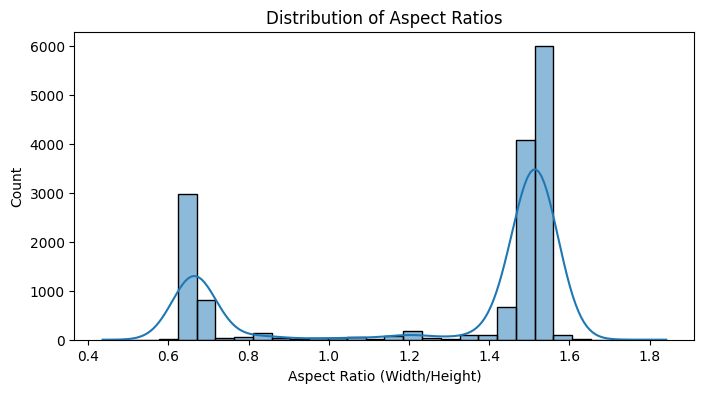


Basic Image Dimension Statistics:
              Width        Height  Aspect Ratio
count  15557.000000  15557.000000  15557.000000
mean     658.585331    544.437231      1.281941
std      104.361474    108.133657      0.367470
min      314.000000    359.000000      0.436111
25%      584.000000    472.000000      0.814453
50%      720.000000    480.000000      1.500000
75%      720.000000    720.000000      1.525424
max      720.000000   1128.000000      1.841432


In [30]:
# Checking aspect ratios
df_image_dims["Aspect Ratio"] = df_image_dims["Width"] / df_image_dims["Height"]
plt.figure(figsize=(8, 4))
sns.histplot(df_image_dims["Aspect Ratio"], bins=30, kde=True)
plt.xlabel("Aspect Ratio (Width/Height)")
plt.title("Distribution of Aspect Ratios")
plt.show()

# Print basic statistics
print("\nBasic Image Dimension Statistics:")
print(df_image_dims.describe())

In [31]:
# Counting unique image sizes
image_size_counts = df_image_dims.groupby(["Width", "Height"]).size().reset_index(name="Count")

# Display the top 10 most common image sizes
print(image_size_counts.sort_values(by="Count", ascending=False).head(10))

# Plotting the most common image sizes



     Width  Height  Count
263    720     472   3976
271    720     480   1747
62     480     720    890
265    720     474    477
268    720     477    438
255    720     464    429
59     477     720    342
270    720     479    334
52     472     720    312
61     479     720    198


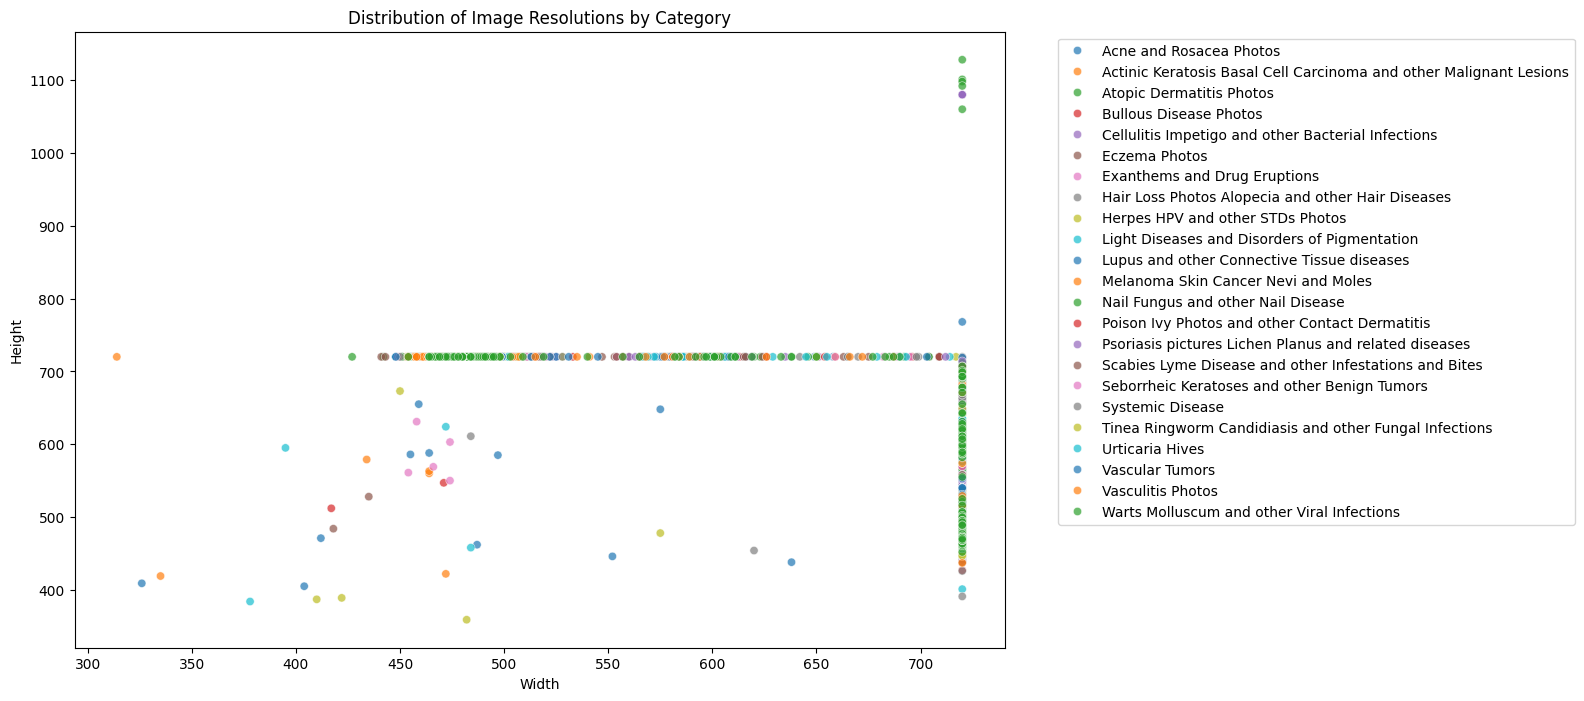

In [35]:
# Convert to DataFrame
df_image_dims = pd.DataFrame(image_dimensions, columns=["Width", "Height"])

# Add a 'Category' column to the DataFrame
categories = []
for category in train_counts.keys():
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        categories.append(category)
df_image_dims['Category'] = categories

# Plotting image size distribution by category
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_image_dims, x="Width", y="Height", hue="Category", alpha=0.7, palette="tab10") # Increased marker size for better visibility
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Resolutions by Category")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Moved legend outside the plot for better readability
plt.show()


### Image Colour Analysis

In [50]:
import os
import cv2
import random
import numpy as np

def calculate_mean_std(directory, categories):
    mean_values = []
    std_values = []

    for category in categories:
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue

        image_files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]  # Filter images only

        if not image_files:  # Skip empty folders
            continue

        for img_name in random.sample(image_files, min(50, len(image_files))):  # Limiting to 50 samples per category
            img_path = os.path.join(category_path, img_name)

            if not os.path.exists(img_path):  # Check if file exists
                print(f"⚠️ Skipping missing file: {img_path}")
                continue

            img = cv2.imread(img_path)
            if img is None:  # Check if image is unreadable
                print(f"⚠️ Skipping unreadable file: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img.astype(np.float32) / 255.0  # Normalize

            mean_values.append(np.mean(img, axis=(0, 1)))  # Mean per channel
            std_values.append(np.std(img, axis=(0, 1)))  # Std per channel

    if not mean_values:  # Ensure lists are not empty before computing mean
        print("🚨 No valid images found in dataset!")
        return None, None

    return np.mean(mean_values, axis=0), np.mean(std_values, axis=0)

# Compute RGB mean and standard deviation
mean_rgb, std_rgb = calculate_mean_std(train_dir, train_counts.keys())

if mean_rgb is not None and std_rgb is not None:
    print(f"✅ Mean RGB Values: {mean_rgb}")
    print(f"✅ Standard Deviation RGB Values: {std_rgb}")
else:
    print("🚨 Could not compute statistics due to missing/invalid images.")


✅ Mean RGB Values: [    0.53319     0.41266     0.38457]
✅ Standard Deviation RGB Values: [    0.19861     0.17128     0.16526]


The height and width of the images vary. so we need to rescale them to a fixed image size (224 x 224)

### Visualize the training and test images

In [7]:
import tensorflow as tf

# Define paths
train_dir = '/content/drive/MyDrive/extracted_data/CV_DermNet/train'
test_dir = '/content/drive/MyDrive/extracted_data/CV_DermNet/test'

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  # Resize images
    batch_size=32,
    # Use 'int' for integer labels or 'categorical' for one-hot encoding
    label_mode='int'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Check class names
print(train_dataset.class_names)
classes = train_dataset.class_names

Found 15557 files belonging to 23 classes.
Found 4002 files belonging to 23 classes.
['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']


In [52]:
print("Total images in training dataset :", len(train_dataset))
print("Total images in test dataset :", len(test_dataset))

Total images in training dataset : 487
Total images in test dataset : 126


In [53]:
len(train_dataset.class_names)

23

In [8]:
# Check class names
class_names = train_dataset.class_names

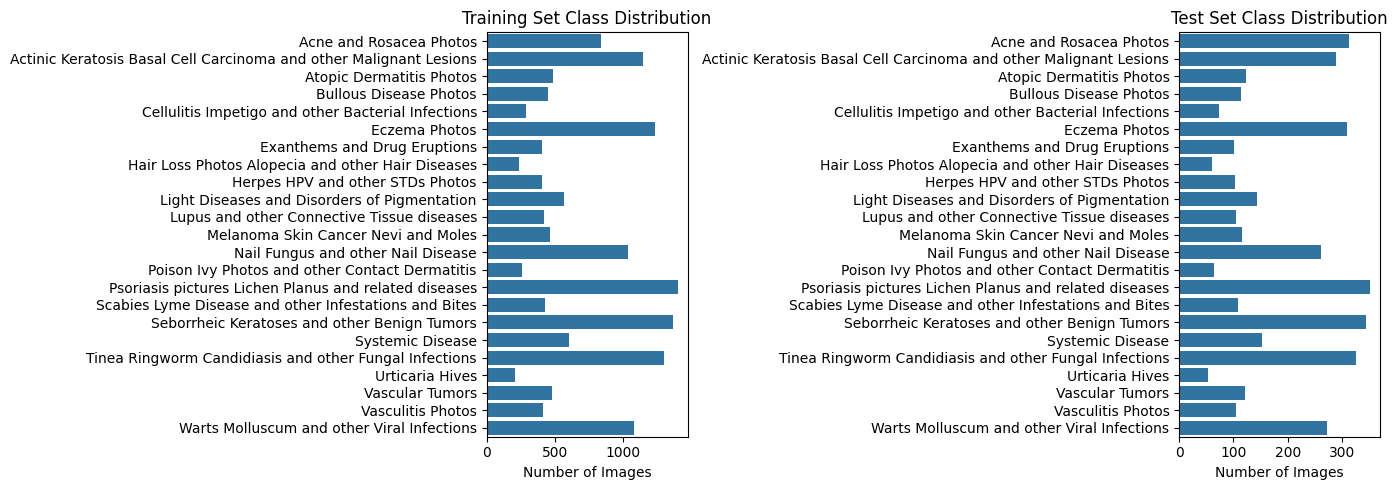

In [54]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# Get class names
class_names = train_dataset.class_names
# Count images per class
train_counts = Counter([label.numpy() for _, labels in train_dataset for label in labels])
test_counts = Counter([label.numpy() for _, labels in test_dataset for label in labels])

# Convert to lists for plotting
train_labels, train_values = zip(*sorted(train_counts.items()))
test_labels, test_values = zip(*sorted(test_counts.items()))

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(x=train_values, y=[class_names[i] for i in train_labels], ax=axes[0])
sns.barplot(x=test_values, y=[class_names[i] for i in test_labels], ax=axes[1])

axes[0].set_title("Training Set Class Distribution")
axes[1].set_title("Test Set Class Distribution")
axes[0].set_xlabel("Number of Images")
axes[1].set_xlabel("Number of Images")

plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap  # To wrap text for long class names

# Function to visualize images with wrapped labels
def show_images(dataset, title, num_images=12):
    class_names = dataset.class_names  # Get class names from dataset
    plt.figure(figsize=(20, 12))
    plt.suptitle(title, fontsize=14)

    # Extract one batch of images
    image_batch, label_batch = next(iter(dataset.take(1)))  # Take 1 batch
    image_batch = image_batch.numpy().astype("uint8")  # Convert to NumPy

    # Plot images
    for i in range(num_images):
        ax = plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
        plt.imshow(image_batch[i])  # Images are already in RGB format
        plt.axis("off")

        # Wrap class names to fit within two lines
        wrapped_label = "\n".join(textwrap.wrap(class_names[label_batch[i].numpy()], width=15))

        # Reduce font size
        plt.title(wrapped_label, fontsize=8)

    plt.show()


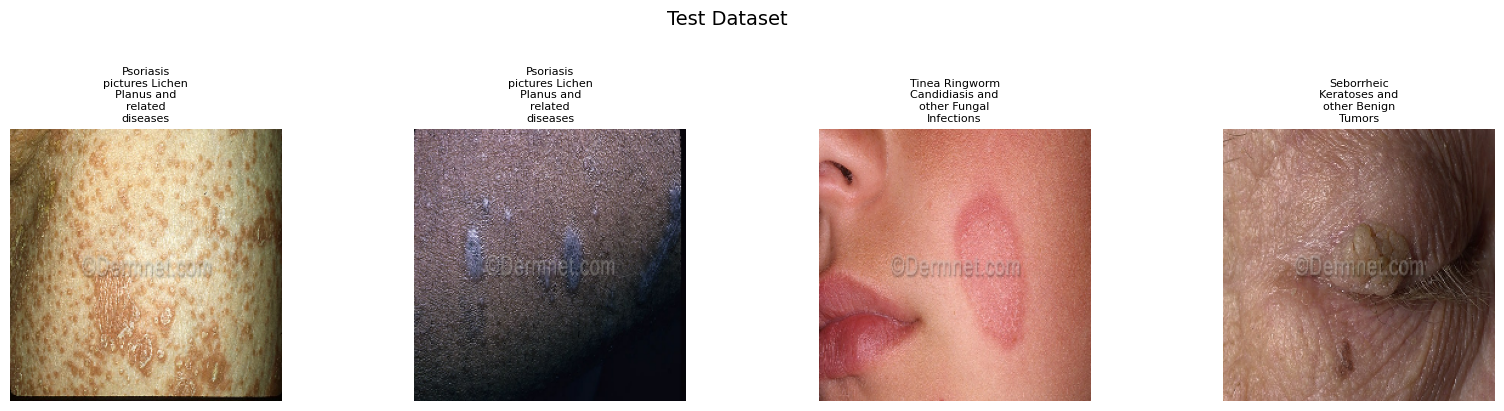

In [8]:
# Show training images
show_images(train_dataset, "Training Dataset", 4)

# Show test images
show_images(test_dataset, "Test Dataset", 4 )

### Image Pixels analysis

In [57]:
intensities = []

for images, _ in train_dataset:
    for image in images:
        intensities.append(image.numpy().mean())
plt.hist(intensities, bins=50)
plt.title('Pixel Intensity Distribution')
plt.show()

### Brightness, sharpness and contrast Distribution

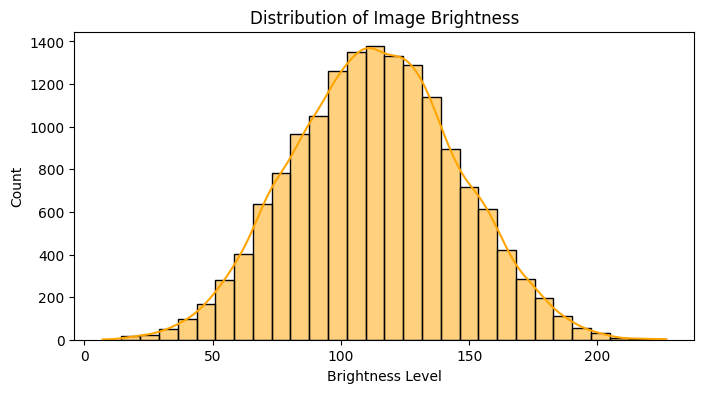

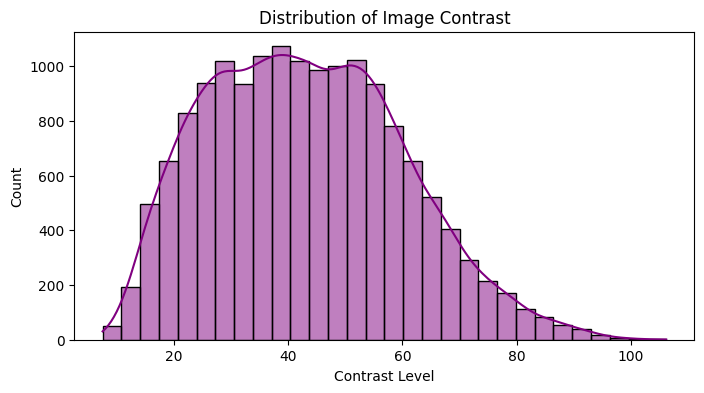

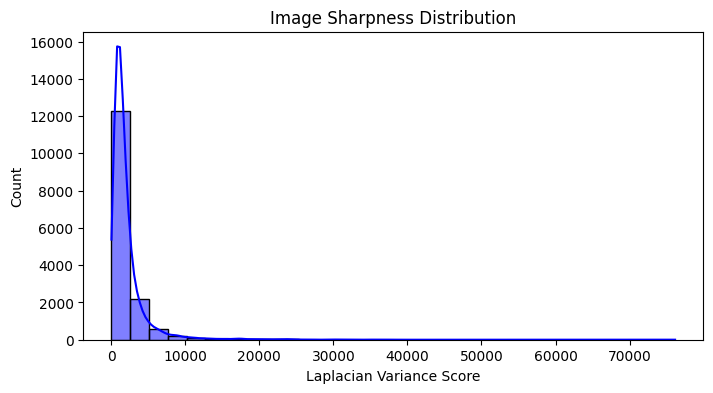

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to compute brightness, sharpness & contrast (optimized)
def get_brightness_contrast(img_batch):
    brightness_list = []
    contrast_list = []
    blur_scores = []
    for img in img_batch:
        gray = cv2.cvtColor(img.numpy().astype(np.uint8), cv2.COLOR_RGB2GRAY)
        brightness_list.append(np.mean(gray))
        contrast_list.append(np.std(gray))
        blur_scores.append(cv2.Laplacian(gray, cv2.CV_64F).var())
    return brightness_list, contrast_list, blur_scores

brightness_all = []
contrast_all = []
blur_all = []

# Process images in batches for efficiency
for img_batch, _ in train_dataset:
    b, c, d = get_brightness_contrast(img_batch)
    brightness_all.extend(b)
    contrast_all.extend(c)
    blur_all.extend(d)

# Plot brightness distribution
plt.figure(figsize=(8, 4))
sns.histplot(brightness_all, bins=30, kde=True, color='orange')
plt.xlabel("Brightness Level")
plt.title("Distribution of Image Brightness")
plt.show()

# Plot contrast distribution
plt.figure(figsize=(8, 4))
sns.histplot(contrast_all, bins=30, kde=True, color='purple')
plt.xlabel("Contrast Level")
plt.title("Distribution of Image Contrast")
plt.show()

# Plot blur score distribution
plt.figure(figsize=(8, 4))
sns.histplot(blur_all, bins=30, kde=True, color='blue')
plt.xlabel("Laplacian Variance Score")
plt.title("Image Sharpness Distribution")
plt.show()


### Image Size distribution

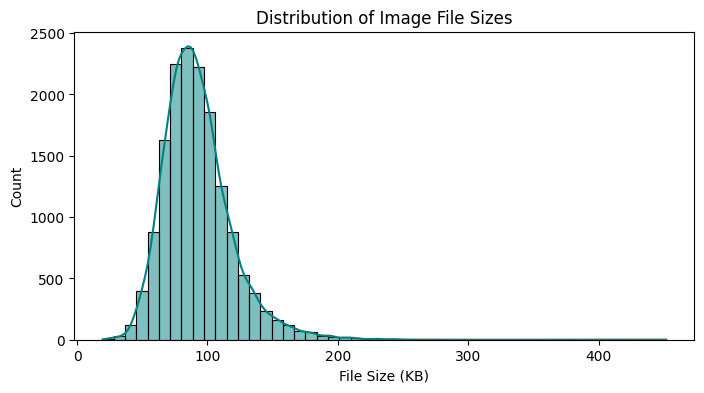

In [11]:
file_sizes = []

for category in train_counts.keys():
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        file_sizes.append(os.path.getsize(img_path) / 1024)  # Convert bytes to KB

# Plot file size distribution
plt.figure(figsize=(8, 4))
sns.histplot(file_sizes, bins=50, kde=True, color='teal')
plt.xlabel("File Size (KB)")
plt.title("Distribution of Image File Sizes")
plt.show()


### Find any duplicate images

In [12]:
from hashlib import md5

def compute_md5(file_path):
    with open(file_path, "rb") as f:
        return md5(f.read()).hexdigest()

image_hashes = {}
duplicates = []

for category in train_counts.keys():
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        # Check if the current item is a file before processing
        if os.path.isfile(img_path):
            img_hash = compute_md5(img_path)
            if img_hash in image_hashes:
                duplicates.append((image_hashes[img_hash], img_path))
            else:
                image_hashes[img_hash] = img_path

# Print duplicate pairs
print(f"Total Duplicates Found: {len(duplicates)}")

Total Duplicates Found: 664


In [13]:
import os
from hashlib import md5

def compute_md5(file_path):
    """Compute the MD5 hash of an image file."""
    with open(file_path, "rb") as f:
        return md5(f.read()).hexdigest()

image_hashes = {}  # Stores hash -> file_path
duplicates = []  # Stores duplicate file paths

for category in train_counts.keys():
    category_path = os.path.join(train_dir, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)

        # Check if the item is a file before processing
        if os.path.isfile(img_path):
            img_hash = compute_md5(img_path)

            if img_hash in image_hashes:
                print(f"🗑 Deleting duplicate: {img_path}")
                os.remove(img_path)  # DELETE duplicate image
                duplicates.append(img_path)  # Store deleted file for reference
            else:
                image_hashes[img_hash] = img_path  # Store hash of unique image

# Print summary
print(f"\n✅ Total Duplicates Removed: {len(duplicates)}")


🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-cystic-12.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-cystic-43.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-excoriated-2.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-open-comedo-14.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-pustular-18.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-pustular-3.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-pustular-6.jpg
🗑 Deleting duplicate: /content/drive/MyDrive/extracted_data/CV_DermNet/train/Acne and Rosacea Photos/acne-pustular-7.jpg
🗑 Deleting duplicate: /cont

### Split the test data into 50% for validation dataset

In [14]:
import tensorflow as tf
import math
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation

# Get the number of batches in the test dataset
total_batches = tf.data.experimental.cardinality(test_dataset).numpy()
val_size = math.ceil(total_batches * 0.5)  # 20% for validation

# Split into validation and test sets
val_dataset = test_dataset.take(val_size)  # Take first 20% as validation
test_dataset = test_dataset.skip(val_size)  # Use remaining 80% as test

print(f"Total test batches: {total_batches}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Remaining test batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")

Total test batches: 126
Validation batches: 63
Remaining test batches: 63


### Normalize the pixels in the images

In [ ]:
# Normalize images
normalization_layer = Rescaling(1./255)

# Apply normalization
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


## Modelling

### Use pre-trained MobileNet Model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from tensorflow.keras import layers, models

# Load the pre-trained model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pre-trained layers

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature map size
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(23, activation='softmax')  # Output layer for 5 flower classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 23)                  │           5,911 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,051,095 (11.64 MB)

 Trainable params: 793,111 (3.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Compile the model
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3  # Change this based on performance
)

Epoch 1/3
487/487 ━━━━━━━━━━━━━━━━━━━━ 472s 949ms/step - accuracy: 0.2054 - loss: 2.7532 - val_accuracy: 0.2907 - val_loss: 2.3993
Epoch 2/3
487/487 ━━━━━━━━━━━━━━━━━━━━ 505s 953ms/step - accuracy: 0.3011 - loss: 2.3707 - val_accuracy: 0.3423 - val_loss: 2.2177
Epoch 3/3
487/487 ━━━━━━━━━━━━━━━━━━━━ 447s 917ms/step - accuracy: 0.3373 - loss: 2.2303 - val_accuracy: 0.3517 - val_loss: 2.1869


In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 811ms/step - accuracy: 0.3709 - loss: 2.2079
Test Accuracy: 0.3590


In [ ]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)  # Get model predictions
    y_true.extend(labels.numpy())  # Store true labels
    y_pred.extend(np.argmax(preds, axis=1))  # Convert softmax output to class index

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 807ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_true, y_pred, target_names=classes))

                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.46      0.66      0.54       158
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.35      0.48      0.41       141
                                          Atopic Dermatitis Photos       0.34      0.25      0.29        60
                                            Bullous Disease Photos       0.08      0.02      0.03        59
                Cellulitis Impetigo and other Bacterial Infections       0.00      0.00      0.00        40
                                                     Eczema Photos       0.35      0.37      0.36       148
                                      Exanthems and Drug Eruptions       0.67      0.09      0.16        43
                 Hair Loss Photos Alopecia and other Hair Diseases       0.40      0.59      0.48        29
                           

C:\Users\abhig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\abhig\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Train the model for Skin Cancer detection based on 5 conditions

- Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions (1149 images) → Pre-cancer & skin cancer
- Melanoma Skin Cancer Nevi and Moles (463 images) → Deadliest form of skin cancer
- Seborrheic Keratoses and other Benign Tumors (1371 images) → Benign vs malignant differentiation
- Psoriasis pictures Lichen Planus and related diseases (1405 images) → Can be misdiagnosed as skin cancer
- Tinea Ringworm Candidiasis and other Fungal Infections (1300 images) → Common misdiagnosis for cancerous lesions


In [ ]:
!pip install sklearn_relief

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import os
import cv2

In [ ]:
# Paths
train_dir = '/content/drive/MyDrive/extracted_data/CV_DermNet/train'
test_dir = '/content/drive/MyDrive/extracted_data/CV_DermNet/test'

# Selected classes for skin cancer detection
selected_classes = [
    "Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions",
    "Melanoma Skin Cancer Nevi and Moles",
    "Seborrheic Keratoses and other Benign Tumors",
    "Psoriasis pictures Lichen Planus and related diseases",
    "Tinea Ringworm Candidiasis and other Fungal Infections"
]

In [ ]:
# Function to filter dataset
def filter_dataset(dataset_path, selected_classes):
    all_classes = os.listdir(dataset_path)
    filtered_classes = [cls for cls in all_classes if cls in selected_classes]
    return filtered_classes

# Get filtered class names
filtered_train_classes = filter_dataset(train_dir, selected_classes)
filtered_test_classes = filter_dataset(test_dir, selected_classes)


In [ ]:
# Load filtered dataset
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    class_names=filtered_train_classes  # Load only selected classes
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    class_names=filtered_test_classes  # Load only selected classes
)
# Print class names to confirm filtering
classes = train_dataset.class_names
print(f"Filtered Classes: {classes}")
# Split test dataset into validation & test (50% each)
val_size = int(0.5 * tf.data.experimental.cardinality(test_dataset).numpy())
val_dataset = test_dataset.take(val_size)
test_dataset = test_dataset.skip(val_size)

# Normalize dataset
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5688 files belonging to 5 classes.
Found 1424 files belonging to 5 classes.
Filtered Classes: ['Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Melanoma Skin Cancer Nevi and Moles', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors', 'Tinea Ringworm Candidiasis and other Fungal Infections']


In [ ]:
from tensorflow.keras.applications import EfficientNetB3, MobileNetV2
from tensorflow.keras import layers, models

# Load the pre-trained model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze pre-trained layers

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature map size
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')  # Output layer for 5 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,046,469 (11.62 MB)

 Trainable params: 788,485 (3.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Train Model
EPOCHS = 5
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 82s 400ms/step - accuracy: 0.3956 - loss: 1.4150 - val_accuracy: 0.5142 - val_loss: 1.1980
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 61s 342ms/step - accuracy: 0.5342 - loss: 1.1049 - val_accuracy: 0.5270 - val_loss: 1.1193
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 69s 387ms/step - accuracy: 0.6182 - loss: 0.9399 - val_accuracy: 0.5568 - val_loss: 1.1393
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 61s 339ms/step - accuracy: 0.6730 - loss: 0.8105 - val_accuracy: 0.5611 - val_loss: 1.2826
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 60s 337ms/step - accuracy: 0.7252 - loss: 0.6922 - val_accuracy: 0.5810 - val_loss: 1.2736


23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.5925 - loss: 1.1965
Test Accuracy: 56.25%


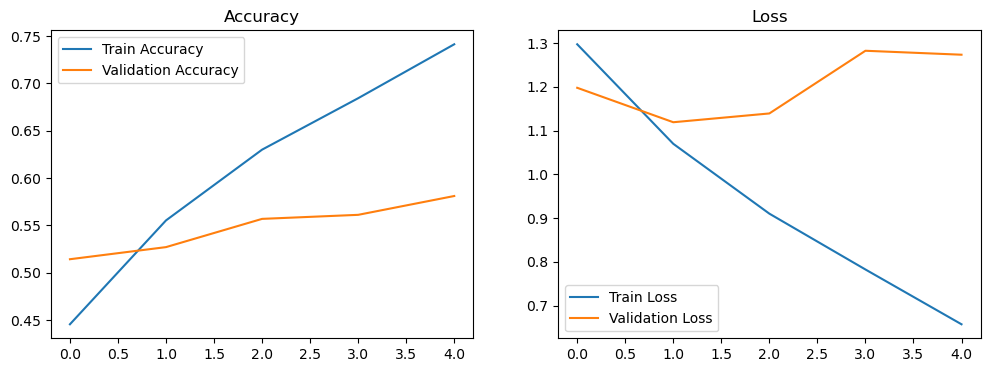

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [ ]:
import numpy as np

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)  # Get model predictions
    y_true.extend(labels.numpy())  # Store true labels
    y_pred.extend(np.argmax(preds, axis=1))  # Convert softmax output to class index

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


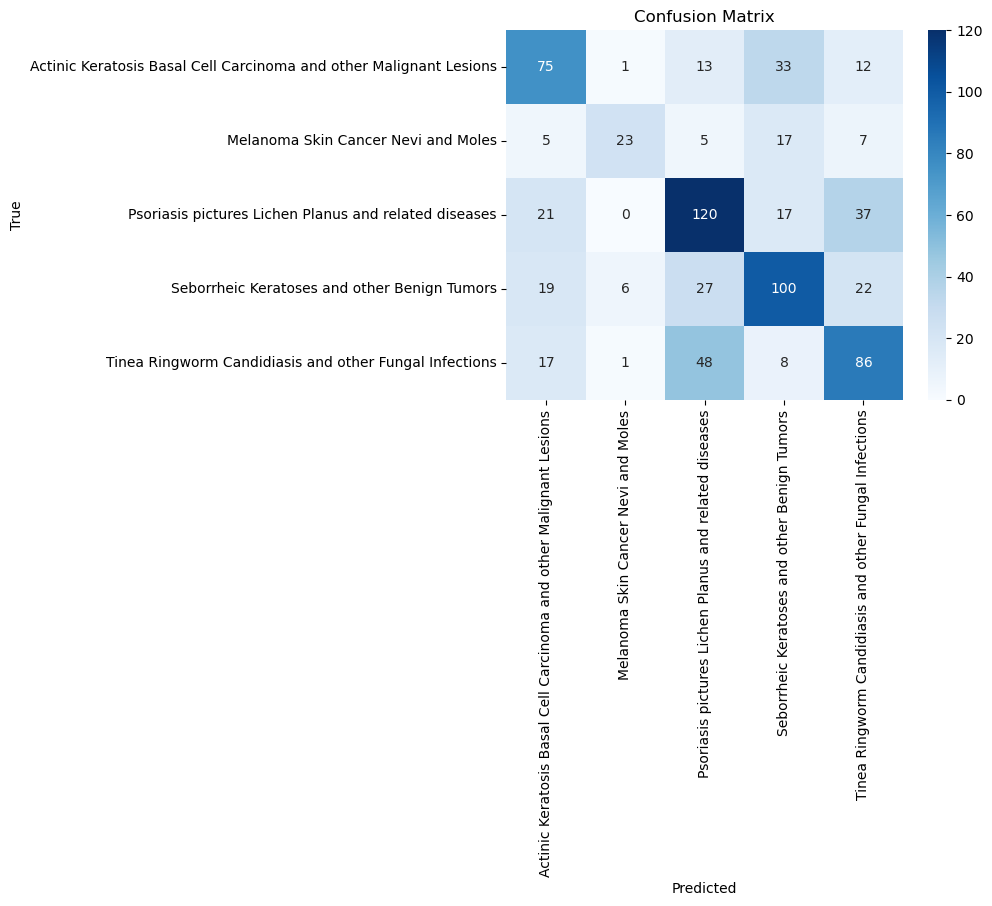

Classification Report:
                                                                     precision    recall  f1-score   support

Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.55      0.56      0.55       134
                               Melanoma Skin Cancer Nevi and Moles       0.74      0.40      0.52        57
             Psoriasis pictures Lichen Planus and related diseases       0.56      0.62      0.59       195
                      Seborrheic Keratoses and other Benign Tumors       0.57      0.57      0.57       174
            Tinea Ringworm Candidiasis and other Fungal Infections       0.52      0.54      0.53       160

                                                          accuracy                           0.56       720
                                                         macro avg       0.59      0.54      0.55       720
                                                      weighted avg       0.57      0.56      0.56       720



In [ ]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

### YOLOv8 for Classification

In [ ]:
pip install ultralytics


In [ ]:
from ultralytics import YOLO
print(YOLO("yolov8n-cls.pt"))  # Check if the model loads

YOLO(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
from ultralytics import YOLO

# Load YOLOv8 classification model
model = YOLO("yolov8n-cls.pt")

# Train the model
model.train(data="/content/drive/MyDrive/extracted_data/CV_DermNet", epochs=20, imgsz=128, batch=32)


Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/content/drive/MyDrive/extracted_data/CV_DermNet, epochs=20, time=None, patience=100, batch=32, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, 

train: Scanning /content/drive/MyDrive/extracted_data/CV_DermNet/train... 15557 images, 0 corrupt: 100%|██████████| 15557/15557 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/extracted_data/CV_DermNet/test... 4002 images, 0 corrupt: 100%|██████████| 4002/4002 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00037, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/classify/train2
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [21:18<00:00, 20.30s/it]

                   all      0.277      0.621



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:34<00:00,  1.51s/it]

                   all      0.356      0.702

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:31<00:00,  1.45s/it]

                   all      0.386       0.73

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:28<00:00,  1.40s/it]

                   all      0.417      0.767

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]

                   all      0.434      0.781

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:20<00:00,  1.28s/it]

                   all      0.458      0.787

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:22<00:00,  1.30s/it]

                   all      0.462      0.807



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:24<00:00,  1.34s/it]

                   all      0.484      0.812

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:23<00:00,  1.33s/it]

                   all      0.491      0.811

      Epoch    GPU_mem       loss  Instances       Size



      10/20         0G      1.644          5        128: 100%|██████████| 487/487 [08:54<00:00,  1.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:21<00:00,  1.29s/it]

                   all      0.502      0.817



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G      1.595          5        128: 100%|██████████| 487/487 [08:43<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:22<00:00,  1.32s/it]

                   all      0.509      0.823

      Epoch    GPU_mem       loss  Instances       Size



      12/20         0G      1.556          5        128: 100%|██████████| 487/487 [08:55<00:00,  1.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:22<00:00,  1.30s/it]

                   all      0.509      0.827

      Epoch    GPU_mem       loss  Instances       Size



      13/20         0G      1.516          5        128: 100%|██████████| 487/487 [08:57<00:00,  1.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:25<00:00,  1.36s/it]

                   all      0.521       0.83

      Epoch    GPU_mem       loss  Instances       Size



      14/20         0G      1.471          5        128: 100%|██████████| 487/487 [08:52<00:00,  1.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:23<00:00,  1.32s/it]

                   all      0.523      0.831

      Epoch    GPU_mem       loss  Instances       Size



      15/20         0G      1.448          5        128: 100%|██████████| 487/487 [08:54<00:00,  1.10s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:27<00:00,  1.40s/it]

                   all      0.529      0.833

      Epoch    GPU_mem       loss  Instances       Size



      16/20         0G      1.416          5        128: 100%|██████████| 487/487 [09:02<00:00,  1.11s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:23<00:00,  1.33s/it]

                   all      0.533      0.837

      Epoch    GPU_mem       loss  Instances       Size



      17/20         0G        1.4          5        128: 100%|██████████| 487/487 [08:47<00:00,  1.08s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:22<00:00,  1.31s/it]

                   all      0.538      0.837

      Epoch    GPU_mem       loss  Instances       Size



      18/20         0G      1.373          5        128: 100%|██████████| 487/487 [08:49<00:00,  1.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:23<00:00,  1.33s/it]

                   all      0.537       0.84

      Epoch    GPU_mem       loss  Instances       Size



      19/20         0G      1.348          5        128: 100%|██████████| 487/487 [08:48<00:00,  1.09s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:21<00:00,  1.30s/it]

                   all       0.54      0.843

      Epoch    GPU_mem       loss  Instances       Size



      20/20         0G      1.343          5        128: 100%|██████████| 487/487 [08:41<00:00,  1.07s/it]
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:22<00:00,  1.31s/it]

                   all      0.543      0.844

20 epochs completed in 4.936 hours.


Optimizer stripped from runs/classify/train2/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train2/weights/best.pt, 3.0MB

Validating runs/classify/train2/weights/best.pt...
Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,464,343 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/extracted_data/CV_DermNet/train... found 15557 images in 23 classes ✅ 
val: None...
test: /content/drive/MyDrive/extracted_data/CV_DermNet/test... found 4002 images in 23 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:20<00:00,  1.28s/it]


                   all      0.543      0.845
Speed: 0.0ms preprocess, 4.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train2


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bd4332b8fd0>
curves: []
curves_results: []
fitness: 0.6940279901027679
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5432283878326416, 'metrics/accuracy_top5': 0.8448275923728943, 'fitness': 0.6940279901027679}
save_dir: PosixPath('runs/classify/train2')
speed: {'preprocess': 0.0003559030494483389, 'inference': 4.865875763371541, 'loss': 2.7104446574333946e-05, 'postprocess': 6.508795242529242e-05}
task: 'classify'
top1: 0.5432283878326416
top5: 0.8448275923728943

In [1]:
import os

print(os.listdir("/content/runs/classify/train2/weights"))  # Check for best.pt


['best.pt', 'last.pt']


In [2]:
import shutil

# Define paths
trained_model_path = "/content/runs/classify/train2/weights/best.pt"
drive_save_path = "/content/drive/MyDrive/best_yolo_model.pt"

# Copy the model to Google Drive
shutil.copy(trained_model_path, drive_save_path)

print(f"Model saved to: {drive_save_path}")



Model saved to: /content/drive/MyDrive/best_yolo_model.pt


In [3]:
import os
from glob import glob
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load YOLO model
from ultralytics import YOLO
model = YOLO("/content/runs/classify/train2/weights/best.pt")  # Adjust path if needed

# Path to test images
test_images_path = "/content/drive/MyDrive/extracted_data/CV_DermNet/test/"
test_images = glob(os.path.join(test_images_path, "*/*.jpg"))  # Adjust if needed

# Get ground truth labels from folder names
true_labels = [os.path.basename(os.path.dirname(img)) for img in test_images]

# Set batch size
BATCH_SIZE = 16  # Adjust based on available memory

# Function to process images in batches
def predict_in_batches(model, image_paths, batch_size):
    predicted_labels = []

    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i : i + batch_size]  # Get batch

        # Run inference
        results = model.predict(batch)

        # Extract predicted class labels
        batch_predictions = [res.probs.top1 for res in results]
        predicted_labels.extend(batch_predictions)

    return predicted_labels

# Run batch prediction
predicted_labels = predict_in_batches(model, test_images, BATCH_SIZE)

# Convert labels to numeric values if needed
unique_labels = sorted(set(true_labels))  # Get class names
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Map class names to indices

y_true = np.array([label_to_index[label] for label in true_labels])  # Convert true labels to indices
y_pred = np.array(predicted_labels)  # Predictions are already numeric




0: 128x128 Acne and Rosacea Photos 0.89, Light Diseases and Disorders of Pigmentation 0.03, Psoriasis pictures Lichen Planus and related diseases 0.03, Atopic Dermatitis Photos 0.02, Eczema Photos 0.01, 6.5ms
1: 128x128 Acne and Rosacea Photos 1.00, Systemic Disease 0.00, Light Diseases and Disorders of Pigmentation 0.00, Lupus and other Connective Tissue diseases 0.00, Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions 0.00, 6.5ms
2: 128x128 Acne and Rosacea Photos 0.73, Light Diseases and Disorders of Pigmentation 0.15, Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions 0.04, Lupus and other Connective Tissue diseases 0.03, Tinea Ringworm Candidiasis and other Fungal Infections 0.02, 6.5ms
3: 128x128 Acne and Rosacea Photos 0.36, Poison Ivy Photos and other Contact Dermatitis 0.21, Psoriasis pictures Lichen Planus and related diseases 0.12, Light Diseases and Disorders of Pigmentation 0.10, Lupus and other Connective Tissue diseases 0.07, 6.5ms
4: 128

✅ Model Accuracy: 0.5432
🔍 Classification Report:
                                                                     precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.73      0.84      0.78       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.61      0.59      0.60       288
                                          Atopic Dermatitis Photos       0.44      0.50      0.46       123
                                            Bullous Disease Photos       0.43      0.32      0.37       113
                Cellulitis Impetigo and other Bacterial Infections       0.47      0.19      0.27        73
                                                     Eczema Photos       0.49      0.60      0.54       309
                                      Exanthems and Drug Eruptions       0.38      0.40      0.39       101
                 Hair Loss Photos Alopecia and other Hair Diseases       0.47      0

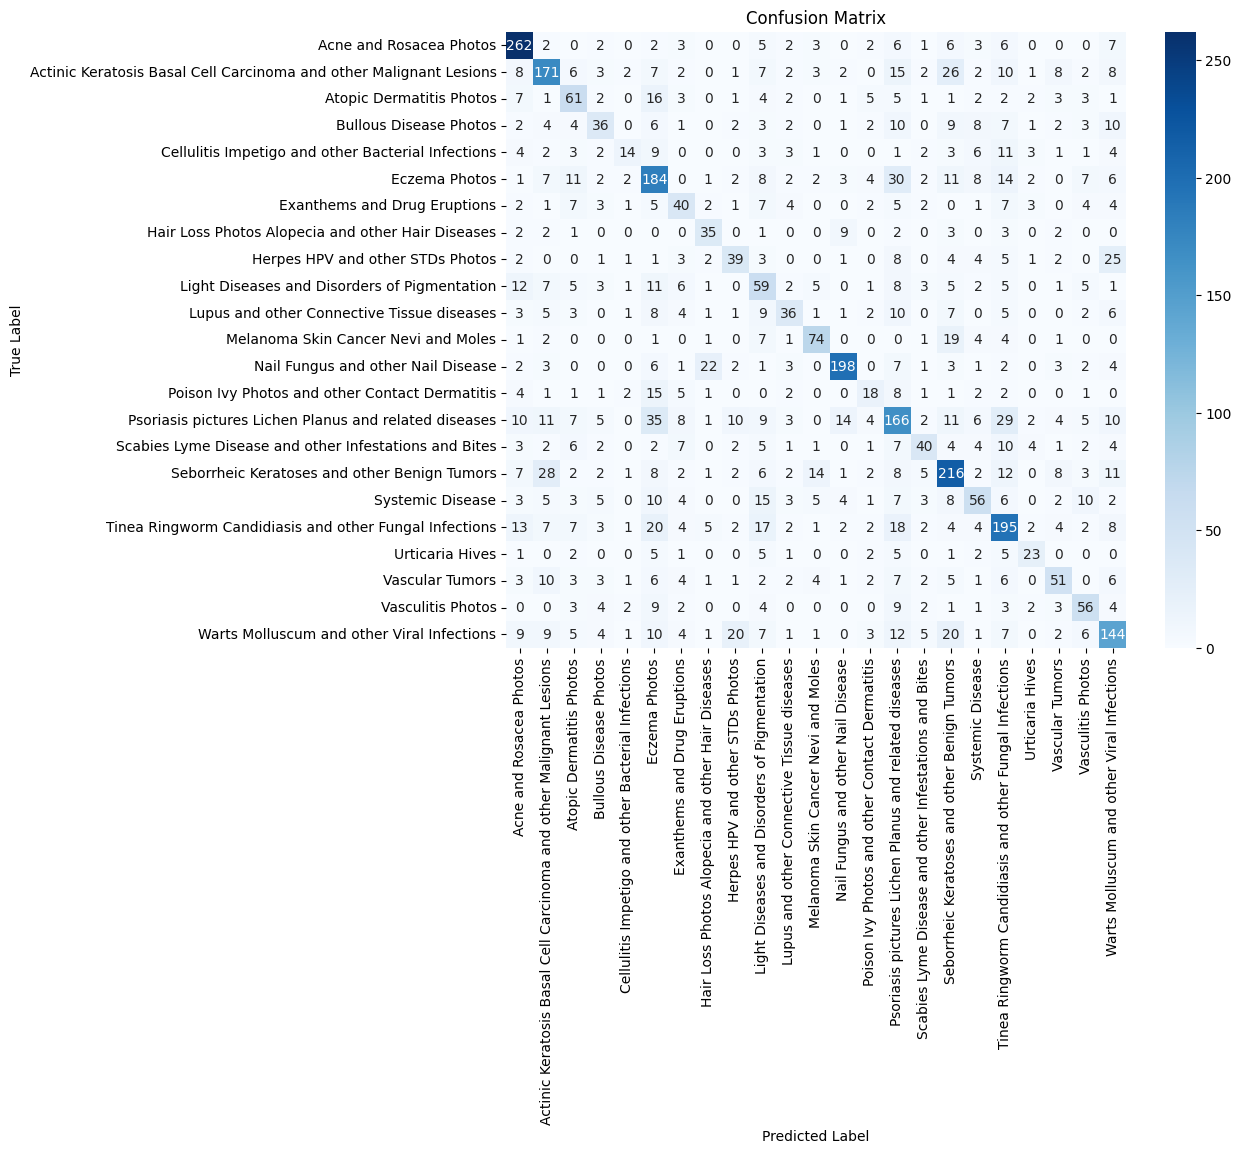

In [13]:
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Generate classification report (Precision, Recall, F1-score)
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("🔍 Classification Report:\n", class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [3]:
from ultralytics import YOLO

# Load the trained model from Drive
model = YOLO("/content/drive/MyDrive/best_yolo_model.pt")

print("Model loaded successfully!")


Model loaded successfully!


Clearly, the model is confusing some of the similar looking conditions like eczema and psorasis.

Let's finetune it further  by setting a learning rate, weight decay and re-train it for more epochs.

In [10]:
from ultralytics import YOLO

# Load existing trained YOLOv8 model
model = YOLO("/content/drive/MyDrive/best_yolo_model.pt")  # Update path if needed


# Fine-tune the model
model.train(
    data="/content/drive/MyDrive/extracted_data/CV_DermNet",
    epochs=30,          # More training on top of previous model
    imgsz=128,          # Higher resolution
    batch=16,           # Ensure batch size fits in memory
    optimizer="Adam",   # Switch to Adam optimizer for better learning
    dropout=0.2,        # Reduce overfitting
    lr0=0.0005,         # Lower learning rate for fine-tuning
    weight_decay=0.0005,# Prevent overfitting
)

Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=/content/drive/MyDrive/best_yolo_model.pt, data=/content/drive/MyDrive/extracted_data/CV_DermNet, epochs=30, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning /content/drive/MyDrive/extracted_data/CV_DermNet/train... 15557 images, 0 corrupt: 100%|██████████| 15557/15557 [00:00<?, ?it/s]
val: Scanning /content/drive/MyDrive/extracted_data/CV_DermNet/test... 4002 images, 0 corrupt: 100%|██████████| 4002/4002 [00:00<?, ?it/s]

optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to runs/classify/train7
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:23<00:00,  1.51it/s]

                   all      0.474      0.807



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]

                   all      0.495      0.823

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:18<00:00,  1.61it/s]

                   all       0.51      0.829



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:16<00:00,  1.64it/s]

                   all      0.512      0.831

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:20<00:00,  1.57it/s]

                   all      0.513      0.835

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:27<00:00,  1.43it/s]

                   all      0.525      0.831

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]

                   all      0.528      0.844

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:22<00:00,  1.52it/s]

                   all       0.53      0.846

      Epoch    GPU_mem       loss  Instances       Size



               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:22<00:00,  1.54it/s]

                   all      0.534      0.841

      Epoch    GPU_mem       loss  Instances       Size



      10/30         0G      1.477          5        128: 100%|██████████| 973/973 [09:13<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:29<00:00,  1.41it/s]

                   all      0.544      0.845



      Epoch    GPU_mem       loss  Instances       Size


      11/30         0G      1.469          5        128: 100%|██████████| 973/973 [09:20<00:00,  1.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:25<00:00,  1.47it/s]

                   all      0.542      0.844

      Epoch    GPU_mem       loss  Instances       Size



      12/30         0G      1.434          5        128: 100%|██████████| 973/973 [09:05<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:25<00:00,  1.48it/s]

                   all      0.546      0.851



      Epoch    GPU_mem       loss  Instances       Size


      13/30         0G      1.417          5        128: 100%|██████████| 973/973 [08:55<00:00,  1.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:24<00:00,  1.49it/s]

                   all      0.556      0.859

      Epoch    GPU_mem       loss  Instances       Size



      14/30         0G      1.373          5        128: 100%|██████████| 973/973 [08:54<00:00,  1.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:26<00:00,  1.45it/s]

                   all      0.557       0.86



      Epoch    GPU_mem       loss  Instances       Size


      15/30         0G      1.352          5        128: 100%|██████████| 973/973 [08:54<00:00,  1.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:45<00:00,  1.20it/s]

                   all      0.553      0.858



      Epoch    GPU_mem       loss  Instances       Size


      16/30         0G      1.321          5        128: 100%|██████████| 973/973 [08:56<00:00,  1.81it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:28<00:00,  1.42it/s]

                   all      0.558      0.866

      Epoch    GPU_mem       loss  Instances       Size



      17/30         0G      1.296          5        128: 100%|██████████| 973/973 [08:59<00:00,  1.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:24<00:00,  1.50it/s]

                   all       0.57      0.865

      Epoch    GPU_mem       loss  Instances       Size



      18/30         0G      1.277          5        128: 100%|██████████| 973/973 [09:20<00:00,  1.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:27<00:00,  1.44it/s]

                   all      0.568      0.861

      Epoch    GPU_mem       loss  Instances       Size



      19/30         0G      1.256          5        128: 100%|██████████| 973/973 [09:26<00:00,  1.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:23<00:00,  1.50it/s]

                   all      0.578      0.861

      Epoch    GPU_mem       loss  Instances       Size



      20/30         0G      1.224          5        128: 100%|██████████| 973/973 [09:07<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:21<00:00,  1.55it/s]

                   all      0.578      0.864



      Epoch    GPU_mem       loss  Instances       Size


      21/30         0G      1.212          5        128: 100%|██████████| 973/973 [08:54<00:00,  1.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:20<00:00,  1.57it/s]

                   all      0.577      0.866



      Epoch    GPU_mem       loss  Instances       Size


      22/30         0G      1.188          5        128: 100%|██████████| 973/973 [09:07<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:22<00:00,  1.52it/s]

                   all      0.583       0.87



      Epoch    GPU_mem       loss  Instances       Size


      23/30         0G       1.18          5        128: 100%|██████████| 973/973 [09:07<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:22<00:00,  1.52it/s]

                   all      0.583      0.869

      Epoch    GPU_mem       loss  Instances       Size



      24/30         0G      1.158          5        128: 100%|██████████| 973/973 [08:44<00:00,  1.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:23<00:00,  1.50it/s]

                   all      0.585      0.868



      Epoch    GPU_mem       loss  Instances       Size


      25/30         0G      1.146          5        128: 100%|██████████| 973/973 [08:36<00:00,  1.88it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:16<00:00,  1.65it/s]

                   all      0.586      0.867

      Epoch    GPU_mem       loss  Instances       Size



      26/30         0G      1.122          5        128: 100%|██████████| 973/973 [08:27<00:00,  1.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:14<00:00,  1.68it/s]

                   all      0.594      0.869

      Epoch    GPU_mem       loss  Instances       Size



      27/30         0G      1.108          5        128: 100%|██████████| 973/973 [08:18<00:00,  1.95it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:19<00:00,  1.58it/s]

                   all      0.594      0.868

      Epoch    GPU_mem       loss  Instances       Size



      28/30         0G      1.099          5        128: 100%|██████████| 973/973 [08:23<00:00,  1.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:18<00:00,  1.60it/s]

                   all      0.592      0.873



      Epoch    GPU_mem       loss  Instances       Size


      29/30         0G      1.077          5        128: 100%|██████████| 973/973 [08:24<00:00,  1.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:14<00:00,  1.68it/s]

                   all      0.594      0.873

      Epoch    GPU_mem       loss  Instances       Size



      30/30         0G      1.079          5        128: 100%|██████████| 973/973 [09:06<00:00,  1.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:20<00:00,  1.56it/s]

                   all      0.593      0.873

30 epochs completed in 5.189 hours.


Optimizer stripped from runs/classify/train7/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train7/weights/best.pt, 3.0MB

Validating runs/classify/train7/weights/best.pt...
Ultralytics 8.3.90 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 30 layers, 1,464,343 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/drive/MyDrive/extracted_data/CV_DermNet/train... found 15557 images in 23 classes ✅ 
val: None...
test: /content/drive/MyDrive/extracted_data/CV_DermNet/test... found 4002 images in 23 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 126/126 [01:23<00:00,  1.51it/s]


                   all      0.595      0.873
Speed: 0.0ms preprocess, 4.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train7


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b374b14add0>
curves: []
curves_results: []
fitness: 0.7338830530643463
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.5949525237083435, 'metrics/accuracy_top5': 0.8728135824203491, 'fitness': 0.7338830530643463}
save_dir: PosixPath('runs/classify/train7')
speed: {'preprocess': 0.0006809018034572205, 'inference': 4.703409105943968, 'loss': 4.4926040253063466e-05, 'postprocess': 0.0001304175404574385}
task: 'classify'
top1: 0.5949525237083435
top5: 0.8728135824203491

The loss is reducing across epochs while the validation accuracy is slightly increased to 60%.

In [12]:
import shutil

# Define paths
trained_model_path = "/content/runs/classify/train7/weights/best.pt"
drive_save_path = "/content/drive/MyDrive/best_yolo_modelv2.pt"

# Copy the model to Google Drive
shutil.copy(trained_model_path, drive_save_path)

print(f"Model saved to: {drive_save_path}")

Model saved to: /content/drive/MyDrive/best_yolo_modelv2.pt


In [14]:
import os
from glob import glob
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load YOLO model
from ultralytics import YOLO
model = YOLO("/content/runs/classify/train7/weights/best.pt")  # Adjust path if needed

# Path to test images
test_images_path = "/content/drive/MyDrive/extracted_data/CV_DermNet/test/"
test_images = glob(os.path.join(test_images_path, "*/*.jpg"))  # Adjust if needed

# Get ground truth labels from folder names
true_labels = [os.path.basename(os.path.dirname(img)) for img in test_images]

# Set batch size
BATCH_SIZE = 16  # Adjust based on available memory

# Function to process images in batches
def predict_in_batches(model, image_paths, batch_size):
    predicted_labels = []

    for i in range(0, len(image_paths), batch_size):
        batch = image_paths[i : i + batch_size]  # Get batch

        # Run inference
        results = model.predict(batch)

        # Extract predicted class labels
        batch_predictions = [res.probs.top1 for res in results]
        predicted_labels.extend(batch_predictions)

    return predicted_labels

# Run batch prediction
predicted_labels = predict_in_batches(model, test_images, BATCH_SIZE)

# Convert labels to numeric values if needed
unique_labels = sorted(set(true_labels))  # Get class names
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Map class names to indices

y_true = np.array([label_to_index[label] for label in true_labels])  # Convert true labels to indices
y_pred = np.array(predicted_labels)  # Predictions are already numeric




0: 128x128 Acne and Rosacea Photos 0.87, Light Diseases and Disorders of Pigmentation 0.05, Atopic Dermatitis Photos 0.03, Psoriasis pictures Lichen Planus and related diseases 0.03, Eczema Photos 0.01, 7.2ms
1: 128x128 Acne and Rosacea Photos 1.00, Systemic Disease 0.00, Lupus and other Connective Tissue diseases 0.00, Light Diseases and Disorders of Pigmentation 0.00, Poison Ivy Photos and other Contact Dermatitis 0.00, 7.2ms
2: 128x128 Acne and Rosacea Photos 0.68, Light Diseases and Disorders of Pigmentation 0.30, Lupus and other Connective Tissue diseases 0.01, Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions 0.01, Exanthems and Drug Eruptions 0.00, 7.2ms
3: 128x128 Acne and Rosacea Photos 0.69, Poison Ivy Photos and other Contact Dermatitis 0.17, Psoriasis pictures Lichen Planus and related diseases 0.05, Eczema Photos 0.04, Lupus and other Connective Tissue diseases 0.02, 7.2ms
4: 128x128 Acne and Rosacea Photos 1.00, Lupus and other Connective Tissue diseases

In [15]:
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"✅ Model Accuracy: {accuracy:.4f}")

# Generate classification report (Precision, Recall, F1-score)
class_report = classification_report(y_true, y_pred, target_names=unique_labels)
print("🔍 Classification Report:\n", class_report)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

✅ Model Accuracy: 0.5950
🔍 Classification Report:
                                                                     precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.78      0.93      0.85       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.66      0.63      0.64       288
                                          Atopic Dermatitis Photos       0.50      0.54      0.52       123
                                            Bullous Disease Photos       0.51      0.43      0.47       113
                Cellulitis Impetigo and other Bacterial Infections       0.43      0.33      0.37        73
                                                     Eczema Photos       0.55      0.64      0.59       309
                                      Exanthems and Drug Eruptions       0.42      0.48      0.45       101
                 Hair Loss Photos Alopecia and other Hair Diseases       0.50      0